This notebook creates a model with a sample from the MNIST data such that only 3 & 7 numbers get identified.
Fast AI can train this in a one line, but idea is to learn SGD

In [1]:
 # All imports
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# All preparation work
# Read data from the path
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
threes = (path/'train/3').ls().sorted() #6131 images of 3
sevens = (path/'train/7').ls().sorted() # 6265 images of 7, total = 12396 of training data
valid = (path/'valid').ls().sorted()
tensor_threes = [tensor(Image.open(i)) for i in threes]
tensor_sevens = [tensor(Image.open(i)) for i in sevens]

# For vision related work, convert all pixel data in range 0 -1
stacked_tensors_threes = torch.stack(tensor_threes).float() / 255.0    #[6131, 28, 28]
stacked_tensors_sevens = torch.stack(tensor_sevens).float() / 255.0    #[6131, 28, 28]

# Do same for validation data, read data, convert pixel data 0-1, 
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255.0 
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255.0

# Prepare x,y for tensor usage -> here each row is one image with 18*28 columns

# Convert a rank 3 tensor to a rank 2 tensor, -1 is a special parameter to view that 
#means "make this axis as big as necessary to fit all the data":
train_x = torch.cat([stacked_tensors_threes, stacked_tensors_sevens]).view(-1, 28*28)  # [12396, 784]
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)

# Create lables for training & validation set
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)                       # [12396, 1]
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

# Dataset in Pytorch is required a return a tuple (x,y) when indexed. zip() with a list is used to achieve this
dset = list(zip(train_x,train_y)) # Each element of dset is a (tensor[784], tensor[1])
valid_dset = list(zip(valid_x,valid_y))

# Here we will use Dataloader object to run mini batches, thus helping it to run in the form of SGD
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [5]:
# Common Functions
# Using Sigmoid function to calculate the loss
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

# Calculating the gradient, takes the data, feed it in a model to get a prediction
# Calculate the loss using the Sigmoid function
# Do the backpropagation to find the gradient
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)  

In [8]:
######################################## RAW Implementation of SGD ####################################################
#######################################################################################################
# Here it takes the data from the data loader to calculate the gradients
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()
            
# Train the model over some epochs 
def train_model(model, epochs, lr):
    for i in range(epochs):
        train_epoch(model, lr)
        print(validate_epoch(model), end=' ')
        
# Sample 
def linear1(xb): 
    return xb@weights + bias

# Parameters initialisation
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

lr = 1.0
weights = init_params((28*28,1))
bias = init_params(1)
params = weights,bias

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')


0.7185 0.8515 0.9135 0.9369 0.9505 0.9608 0.9657 0.9667 0.9691 0.9701 0.9706 0.9706 0.9716 0.9721 0.974 0.9731 0.974 0.9745 0.976 0.9765 

In [10]:
# An optimiser can be something like this
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

linear_model = nn.Linear(28*28,1)   
opt = BasicOptim(linear_model.parameters(), lr)
            

In [11]:
############################################ SGD using pytorch Library Calls ############################################################
###########################################################################################################################
# opt.step() is the gradient descnet step where it updates the parameter = gradient * lr. SGD takes care of this
# loss.backward() in calc_grad() calculates the gradients and add them to the existing one
# So zero_grad() is called to update the gradient value to 0, where it sets the weight & bias to 0 
def train_epoch_sgd(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

def train_model_sgd(model, epochs):
    for i in range(epochs):
        train_epoch_sgd(model)
        print(validate_epoch(model), end=' ')
        

#Using SGD         
lr = 1.0
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model_sgd(linear_model, 20)


0.4932 0.8481 0.8281 0.9106 0.934 0.9472 0.9555 0.9618 0.9653 0.9682 0.9692 0.9716 0.9741 0.975 0.976 0.977 0.9775 0.978 0.9785 0.9785 

Train by Fast AI Library Function Learner() which warps the train_epoch() and train_model() functions. DataLoaders is a FASTAI class which takes multiple pytorch dataloader.

In [12]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636839,0.503688,0.495584,00:00
1,0.626936,0.130309,0.912659,00:00
2,0.226317,0.283088,0.723258,00:00
3,0.097773,0.135289,0.882237,00:00
4,0.050047,0.090611,0.921001,00:00
5,0.031451,0.069645,0.939647,00:00
6,0.023786,0.057385,0.951914,00:00
7,0.020406,0.049479,0.960255,00:00
8,0.018734,0.044078,0.964671,00:00
9,0.017764,0.040197,0.966143,00:00


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.320865,0.424981,0.504416,00:00
1,0.150803,0.237268,0.794897,00:00
2,0.082852,0.117884,0.914132,00:00
3,0.054063,0.078922,0.939156,00:00
4,0.040772,0.061328,0.956330,00:00
5,0.034008,0.051554,0.963690,00:00
6,0.030142,0.045433,0.965162,00:00
7,0.027643,0.041266,0.966143,00:00
8,0.025850,0.038241,0.968597,00:00
9,0.024464,0.035935,0.970559,00:00


0.983316957950592

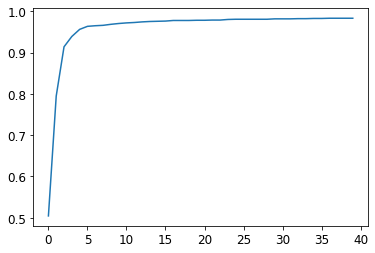

In [8]:
# Using non linearity, Using neural network
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)
# Plots the accuracy of the model
plt.plot(L(learn.recorder.values).itemgot(2));
learn.recorder.values[-1][2]

Train by Fast AI Optimised Function - One liner - better performance with only one epoch

In [33]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.143675,0.019299,0.997056,07:09
